# Part 3: Sentiment Analysis [50 points]

Download data from: http://www.andrew.cmu.edu/user/georgech/HW3-data.zip <br>

The folder contains:

- train.csv
- test.csv

**Remark**: Again, just as with the first problem (3.1 on classification), we begin with some imports and also initialize a random number generator (which you didn't have to do). Our solutions below uses `pandas` (you are *not* required to have a solution that uses `pandas`).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow
from glob import glob

rng = np.random.RandomState(0)

# these next two lines aim to make the output of Keras (when using TensorFlow
# as the backend) deterministic (we do not expect that your code does this;
# also this does not necessarily guarantee the output on different machines
# to be identical)
np.random.seed(1)
tensorflow.set_random_seed(2)

/media/latte/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### (a) Read the training data  [5 Points]

Read the data present in train.csv file. **Please do no change the file name. In particular, use a relative path, i.e., './HW3-data/train.csv'** <br>
Perform the following cleaning on the data:
1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Shuffle the rows of the data frame such that the positive and negative tweets are mixed
3. Print the first 5 sentiments.
4. Print the number of positive and negative sentiment labels
Note: If you are using `open()`, you may have to set `encoding='iso8859'`.

In [2]:
import warnings
warnings.filterwarnings('ignore')

# note: you do not have to use pandas
def read_data(csv_filename):
    import pandas as pd
    df = pd.read_csv(csv_filename, header=None, encoding='iso8859')

    df = df[df.columns[[0, 5]]]
    df.columns = ['Sentiment', 'Text']
    df = df[df.Sentiment.isnull() == False]
    df['Sentiment'] = df['Sentiment'].map(int)
    df = df[df['Text'].isnull() == False]
    df = df.sample(frac=1)
    print(df.head(5))
    df.groupby('Sentiment').count()
    return df

df = read_data('HW3-data/train.csv')

        Sentiment                                               Text
514293          0  i miss nikki nu nu already  shes always there ...
142282          0  So I had a dream last night. I  remember a sig...
403727          0  @girlyghost ohh poor sickly you   (((hugs)) ho...
649503          0                               it is raining again 
610789          0          @MissKeriBaby wish I was in LA right now 


### (b) Data Preparation [7 points]

Before building a neural network model, we first need to prepare the data. The input to a RNN model  is a matrix with shape (a, b), where a is the number of samples (tweets), and b is the sequence length of each tweet. Prepare the data with the following steps:

1\. Take the RAW texts of the top 5000 tweets in the data and convert them to a list of strings, where each string is a tweet. [1 pt]

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

max_len = 120
max_words = 10000

texts = list(df['Text'].head(5000))
labels = df['Sentiment'].head(5000)

Using TensorFlow backend.


2\. Use `Tokenizer` from `keras.preprocessing.text` to tokenize the texts and convert them to sequences (numbers) with `texts_to_sequences` method of `Tokenizer`. **When tokenizing, please only consider the top 10,000 words in the dataset (`num_words`=10,000)**. [4 pts]

In [4]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

3\. Use `pad_sequences` from `keras.preprocessing.sequence` to pad each sequence with zeros to **make the sequence length 120**. [2 pts]

In [5]:
data = pad_sequences(sequences, maxlen=max_len)

###  (c) Simple RNN [20 points]

i) [8 points] Build a simple RNN model with the following specification:
1. An embedding layer with output dimenstion 64.
2. A simple RNN layer.
3. A dense layer with sigmoid activation function for prediction.
Print the summary of the model.

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

simple_rnn_model = Sequential()
simple_rnn_model.add(Embedding(max_words, 64, input_length=max_len))
simple_rnn_model.add(SimpleRNN(64))
simple_rnn_model.add(Dense(1, activation='sigmoid'))
simple_rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 64)           640000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 648,321
Trainable params: 648,321
Non-trainable params: 0
_________________________________________________________________


ii) [12 points] Now train the simple RNN model:

1\. Compile the model with binary cross entory as loss and accuracy as evaluation metrics.

2\. Fit the model with the training set with 5 epochs (use 20% of the data as validation). Play with the batch size to find a value that seems to work well (for example, you may find a smaller choice like 32 to result in extremely slow learning; try larger values like 512, 1024, etc).

3\. Plot the training and validation accuracies across epochs.

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 1s 280us/step - loss: 0.7030 - acc: 0.5098 - val_loss: 0.6887 - val_acc: 0.5440
Epoch 2/5
4000/4000 [==============================] - 0s 56us/step - loss: 0.6311 - acc: 0.7495 - val_loss: 0.6885 - val_acc: 0.5460
Epoch 3/5
4000/4000 [==============================] - 0s 59us/step - loss: 0.5686 - acc: 0.8475 - val_loss: 0.6945 - val_acc: 0.5060
Epoch 4/5
4000/4000 [==============================] - 0s 59us/step - loss: 0.4965 - acc: 0.9065 - val_loss: 0.6881 - val_acc: 0.5340
Epoch 5/5
4000/4000 [==============================] - 0s 66us/step - loss: 0.4363 - acc: 0.9412 - val_loss: 0.7086 - val_acc: 0.5190


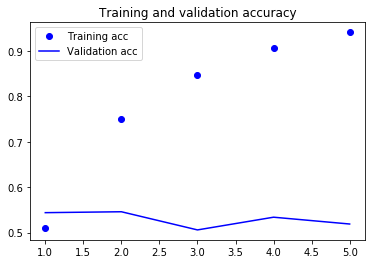

In [7]:
simple_rnn_model.compile(optimizer='rmsprop',
                         loss = 'binary_crossentropy',
                         metrics=['acc'])

rnn_history = simple_rnn_model.fit(data, labels,
                                   validation_split=0.2,
                                   epochs=5,
                                   batch_size=1024)

def accuracy_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

accuracy_plot(rnn_history)

### LSTM [4 points] 

i) [2 point] Now built a LSTM model by replacing the simple RNN layter in the above model with a LSTM layer. Print a summary of the LSTM model.

In [8]:
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(Embedding(max_words, 64, input_length=max_len))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 64)           640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


ii) [2 point] Train the LSTM model with the same specifications in the simple RNN model. Again, plot the training and validation accuracy for each epoch.

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 1s 291us/step - loss: 0.6920 - acc: 0.5355 - val_loss: 0.6885 - val_acc: 0.5900
Epoch 2/5
4000/4000 [==============================] - 1s 182us/step - loss: 0.6800 - acc: 0.6762 - val_loss: 0.6743 - val_acc: 0.6560
Epoch 3/5
4000/4000 [==============================] - 1s 180us/step - loss: 0.6525 - acc: 0.6482 - val_loss: 0.6603 - val_acc: 0.6630
Epoch 4/5
4000/4000 [==============================] - 1s 187us/step - loss: 0.6153 - acc: 0.8133 - val_loss: 0.6381 - val_acc: 0.6810
Epoch 5/5
4000/4000 [==============================] - 1s 180us/step - loss: 0.5600 - acc: 0.8022 - val_loss: 0.6128 - val_acc: 0.6590


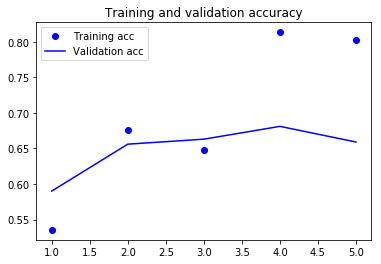

In [9]:
lstm_model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics=['acc'])

lstm_history = lstm_model.fit(data, labels,
                              validation_split=0.2,
                              epochs=5,
                              batch_size=1024)

accuracy_plot(lstm_history)

### (e) Evaluation on test data [14 points]

i) [5 points] Using the simple RNN and LSTM models from the previous parts (do *not* retrain these using the full training dataset; it's fine to use the same models you learned from before where technically 20% of the training data were held out as validation data), evaluate their performance on the *test* set (`test.csv`). What are the test set raw accuracies that you get?

In [10]:
test_df = read_data('HW3-data/test.csv')
test_texts = list(test_df['Text'])
test_labels = test_df['Sentiment']
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(test_sequences, maxlen=max_len)

simple_rnn_test_loss, simple_rnn_test_acc = simple_rnn_model.evaluate(test_data, test_labels)
print('SimpleRNN test set accuracy:', simple_rnn_test_acc)

lstm_test_loss, lstm_test_acc = lstm_model.evaluate(test_data, test_labels)
print('LSTM model test set accuracy:', lstm_test_acc)

     Sentiment                                               Text
473          0   Off to the bank to get my new visa platinum card
348          0  Learning jQuery 1.3 Book Review - http://cfblo...
174          0  Sony coupon code.. Expires soon.. http://www.c...
184          0        The safeway bathroom still smells like ass!
463          1  GOT MY WAVE SANDBOX INVITE! Extra excited! Too...
498/498 [==============================] - 0s 856us/step
SimpleRNN test set accuracy: 0.6164658639325674
498/498 [==============================] - 1s 2ms/step
LSTM model test set accuracy: 0.4497991971462127


ii) [9 points] In the previous models, we only use the top 5000 tweets. Now train the LSTM-based model using the whole training dataset. Again use 20% of the training dataset as validation. After learning the model, test it on the true test set. What is the test set raw accuracy that you get? How does this test set accuracy compare to the validation accuracy, and to the test set accuracy you got from using only 5000 tweets (or technically 5000\*0.8=4000 tweets to train)?

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 64)           640000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________
Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
1280000/1280000 [==============================] - 228s 178us/step - loss: 0.4413 - acc: 0.7950 - val_loss: 0.4115 - val_acc: 0.8105
Epoch 2/5
1280000/1280000 [==============================] - 227s 177us/step - loss: 0.3997 - acc: 0.8181 - val_loss: 0.4008 - val_acc: 0.8180
Epoch 3/5
1280000/1280000 [==============================] - 

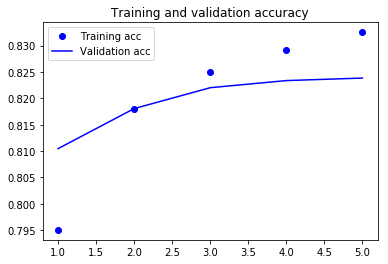

498/498 [==============================] - 1s 2ms/step
LSTM model test set accuracy (training using bigger dataset): 0.6465863460996544


In [11]:
all_texts = list(df['Text'])
all_tokenizer = Tokenizer(num_words=max_words)
all_tokenizer.fit_on_texts(all_texts)
all_sequences = all_tokenizer.texts_to_sequences(all_texts)
all_labels = df['Sentiment']

all_data = pad_sequences(all_sequences, maxlen=max_len)

lstm_model_big = Sequential()
lstm_model_big.add(Embedding(max_words, 64, input_length=max_len))
lstm_model_big.add(LSTM(64))
lstm_model_big.add(Dense(1, activation='sigmoid'))
lstm_model_big.summary()

lstm_model_big.compile(optimizer='rmsprop',
                       loss = 'binary_crossentropy',
                       metrics=['acc'])

lstm_history_big = lstm_model_big.fit(all_data, all_labels,
                                      validation_split=0.2,
                                      epochs=5,
                                      batch_size=1024)

accuracy_plot(lstm_history_big)

# the test dataset is still the same size (in terms of number of examples);
# however we use `all_tokenizer` now instead of `tokenizer`
test_sequences_big = all_tokenizer.texts_to_sequences(test_texts)
test_data_big = pad_sequences(test_sequences_big, maxlen=max_len)
lstm_test_loss_big, lstm_test_acc_big = lstm_model_big.evaluate(test_data_big, test_labels)
print('LSTM model test set accuracy (training using bigger dataset):', lstm_test_acc_big)

Unsurprisingly, the test set accuracy is dramatically higher when we fit the LSTM model using the full training dataset compared to using only 5000 samples. For comparison, we also fit the simple RNN model using the full training dataset below and evaluate on the test set (in this case, the simple RNN model does slightly better than the LSTM model; note that the performance gap between the two is much smaller than in the case where we train using only 5000 samples):

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 64)           640000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 648,321
Trainable params: 648,321
Non-trainable params: 0
_________________________________________________________________
Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
1280000/1280000 [==============================] - 95s 74us/step - loss: 0.4635 - acc: 0.7841 - val_loss: 0.4378 - val_acc: 0.7996
Epoch 2/5
1280000/1280000 [==============================] - 96s 75us/step - loss: 0.4223 - acc: 0.8076 - val_loss: 0.4184 - val_acc: 0.8084
Epoch 3/5
1280000/1280000 [==============================] - 98s 

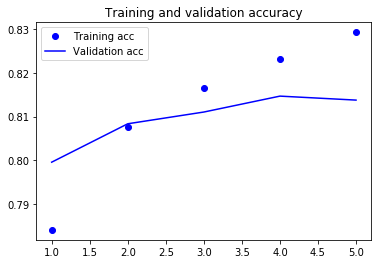

498/498 [==============================] - 0s 876us/step
Simple RNN model test set accuracy (training using bigger dataset): 0.6546184734168302


In [12]:
simple_rnn_model_big = Sequential()
simple_rnn_model_big.add(Embedding(max_words, 64, input_length=max_len))
simple_rnn_model_big.add(SimpleRNN(64))
simple_rnn_model_big.add(Dense(1, activation='sigmoid'))
simple_rnn_model_big.summary()

simple_rnn_model_big.compile(optimizer='rmsprop',
                             loss = 'binary_crossentropy',
                             metrics=['acc'])

simple_rnn_history_big = simple_rnn_model_big.fit(all_data, all_labels,
                                                  validation_split=0.2,
                                                  epochs=5,
                                                  batch_size=1024)

accuracy_plot(simple_rnn_history_big)
simple_rnn_test_loss_big, simple_rnn_test_acc_big = simple_rnn_model_big.evaluate(test_data_big, test_labels)
print('Simple RNN model test set accuracy (training using bigger dataset):', simple_rnn_test_acc_big)